In [29]:
import os
from matplotlib import pyplot as plt
import numpy as np
import time as tm
from scipy import interpolate as it
from itertools import chain
import warnings
import pandas as pd
import datetime as dt
warnings.filterwarnings('ignore')
%run FC_functions

In [30]:
'''
Experimental Parameter
'''
# visible beam centered at
vis_wl = 795.
vis_wn = to_wn(vis_wl)
# thickness of gold
d_gold = 0

# beam angles
θ_air_IR  = 64
θ_air_vis = 47

In [31]:
%run h2o_ni_caf2
mylib = opt_cst_lib(m1, m2, m3)
path = '/Users/ricoxi/Desktop/Coding/Fresnel Factor/'
os.chdir(path)

def get_h2o():

    # list of IR wn of which the final output will be plotted against
    IR_wn = [mylib.m1_ir[i][0] for i in range(len(mylib.m1_ir))]
    IR_wl = [to_wl(mylib.m1_ir[i][0]) for i in range(len(mylib.m1_ir))]

    # list of sfg wn
    sfg_wn = [IR_wn[i] + vis_wn for i in range(len(IR_wn))]
    sfg_wl = [to_wn(i) for i in sfg_wn]

    '''
    m1 = SAPPHIRE
    m2 = GOLD
    m3 = WATER
    '''

    ind_1_IR = [complex(i[1],i[2]) for i in mylib.m1_ir]
    ind_2_IR = [complex(i[1],i[2]) for i in mylib.m2_ir]
    ind_3_IR = [complex(i[1],i[2]) for i in mylib.m3_ir]

    ind_1_vis = complex(mylib.m1_vis[1],mylib.m1_vis[2])
    ind_2_vis = complex(mylib.m2_vis[1],mylib.m2_vis[2])
    ind_3_vis = complex(mylib.m3_vis[1],mylib.m3_vis[2])

    ind_1_sfg = [complex(i[1],i[2]) for i in mylib.m1_sfg]
    ind_2_sfg = [complex(i[1],i[2]) for i in mylib.m2_sfg]
    ind_3_sfg = [complex(i[1],i[2]) for i in mylib.m3_sfg]

    '''
    All the angles in the world
    '''
    θ_1_IR = [from_air(to_rad(θ_air_IR), i) for i in ind_1_IR]
    θ_2_IR = [refract(i[0], i[1], i[2]) for i in zip(θ_1_IR, ind_1_IR, ind_2_IR)]
    θ_3_IR = [refract(i[0], i[1], i[2]) for i in zip(θ_2_IR, ind_2_IR, ind_3_IR)]

    θ_1_vis = from_air(to_rad(θ_air_vis), ind_1_vis)
    θ_2_vis = refract(θ_1_vis, ind_1_vis, ind_2_vis)
    θ_3_vis = refract(θ_2_vis, ind_2_vis, ind_3_vis)

    θ_1_sfg = [sfg_angle(i[0],vis_wn,i[1],i[2],θ_1_vis,i[3],ind_1_vis,i[4]) for i in 
                zip(IR_wn, sfg_wn, θ_1_IR, ind_1_IR, ind_1_sfg)]
    θ_2_sfg = [refract(i[0], i[1], i[2]) for i in zip(θ_1_sfg, ind_1_sfg, ind_2_sfg)]
    θ_3_sfg = [refract(i[0], i[1], i[2]) for i in zip(θ_2_sfg, ind_2_sfg, ind_3_sfg)]

    '''
    Calculations of Fresnel Parameters
    '''
    # =========================================== #
    β_ir = [beta(i[0], i[1], d_gold, i[2]) for i in zip(IR_wl, ind_2_IR, θ_2_IR)]
    Δ_ir = [delta_ir(i[0], vis_wl, i[1], i[2], d_gold, i[3], i[4], i[5])
           for i in zip(IR_wl, ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR, θ_2_sfg)]

    β_vis = beta(vis_wl, ind_2_vis, d_gold, θ_2_vis)
    Δ_vis = delta_vis(vis_wl, ind_1_vis, ind_2_vis, d_gold, θ_1_vis, θ_2_vis, θ_2_sfg)

    β_sfg = [beta(i[0], i[1], d_gold, i[2]) for i in zip(sfg_wl, ind_2_sfg, θ_2_sfg)]
    Δ_sfg = [delta_sfg(i[0], i[1], d_gold, i[2])
           for i in zip(sfg_wl, ind_2_sfg, θ_2_sfg)]
    # =========================================== #
    r_12_p_ir = [r_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
    t_12_p_ir = [t_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
    r_23_p_ir = [r_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]
    t_23_p_ir = [t_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]

    r_12_s_ir = [r_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
    t_12_s_ir = [t_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
    r_23_s_ir = [r_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]
    t_23_s_ir = [t_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]
    # =========================================== #
    L_I_xx_ir = [L_I_xx(i[0],i[1],i[2],i[3],i[4],i[5]) 
                  for i in zip(t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, θ_2_IR, θ_1_IR)]
    L_I_yy_ir = [L_I_yy(i[0],i[1],i[2],i[3])
                  for i in zip(t_12_s_ir, r_12_s_ir, r_23_s_ir, β_ir)]
    L_I_zz_ir = [L_I_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
                  for i in zip(t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, ind_1_IR, ind_2_IR, ind_2_IR)]

    L_II_xx_ir = [L_II_xx(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
                  for i in zip(Δ_ir, t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, θ_2_IR, θ_1_IR)]
    L_II_yy_ir = [L_II_yy(i[0],i[1],i[2],i[3],i[4])
                  for i in zip(Δ_ir, t_12_s_ir, r_12_s_ir, r_23_s_ir, β_ir)]
    # chi(2) water is large chi(2) nickel, 
    L_II_zz_ir_h2o = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
                  for i in zip(Δ_ir, t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, ind_1_IR, ind_2_IR, ind_3_IR)]
    # # chi(2) nickel is large chi(2) water, 
    L_II_zz_ir_n   = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
                  for i in zip(Δ_ir, t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, ind_1_IR, ind_2_IR, ind_2_IR)]
    L_II_zz_ir = {'h2o': L_II_zz_ir_h2o, 'nickel': L_II_zz_ir_n}
    # =========================================== #
    L_I_xx_ir_sq = [i * i.conjugate() for i in L_I_xx_ir]
    L_I_yy_ir_sq = [i * i.conjugate() for i in L_I_yy_ir]
    L_I_zz_ir_sq = [i * i.conjugate() for i in L_I_zz_ir]

    L_II_xx_ir_sq = [i * i.conjugate() for i in L_II_xx_ir]
    L_II_yy_ir_sq = [i * i.conjugate() for i in L_II_yy_ir]
    L_II_zz_ir_sq = {'h2o': [i * i.conjugate() for i in L_II_zz_ir['h2o']], 'nickel': [i * i.conjugate() for i in L_II_zz_ir['nickel']]}

    # ====================================================================================== #
    # ====================================================================================== #
    # ====================================================================================== #
    r_12_p_vis = r_ij_p(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
    t_12_p_vis = t_ij_p(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
    r_23_p_vis = r_ij_p(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)
    t_23_p_vis = t_ij_p(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)

    r_12_s_vis = r_ij_s(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
    t_12_s_vis = t_ij_s(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
    r_23_s_vis = r_ij_s(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)
    t_23_s_vis = t_ij_s(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)
    # =========================================== #
    L_I_xx_vis = [L_I_xx(t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, θ_2_vis, θ_1_vis) for i in ind_1_IR]
    L_I_yy_vis = [L_I_yy(t_12_s_vis, r_12_s_vis, r_23_s_vis, β_vis) for i in ind_1_IR]
    L_I_zz_vis = [L_I_zz(t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, ind_1_vis, ind_2_vis, ind_2_vis) for i in ind_1_IR]

    L_II_xx_vis = [L_II_xx(Δ_vis, t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, θ_2_vis, θ_1_vis)]
    L_II_xx_vis = list(chain.from_iterable(L_II_xx_vis))
    L_II_yy_vis = [L_II_yy(Δ_vis, t_12_s_vis, r_12_s_vis, r_23_s_vis, β_vis)]
    L_II_yy_vis = list(chain.from_iterable(L_II_yy_vis))
    # chi(2) water is large chi(2) nickel, 
    L_II_zz_vis_h2o = [L_II_zz(Δ_vis, t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, ind_1_vis, ind_2_vis, ind_3_vis)]
    L_II_zz_vis_h2o = list(chain.from_iterable(L_II_zz_vis_h2o))
    # # chi(2) nickel is large chi(2) water, 
    L_II_zz_vis_n   = [L_II_zz(Δ_vis, t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, ind_1_vis, ind_2_vis, ind_2_vis)]
    L_II_zz_vis_n = list(chain.from_iterable(L_II_zz_vis_n))
    L_II_zz_vis = {'h2o': L_II_zz_vis_h2o, 'nickel': L_II_zz_vis_n}
    # =========================================== #
    L_I_xx_vis_sq = [i * i.conjugate() for i in L_I_xx_vis]
    L_I_yy_vis_sq = [i * i.conjugate() for i in L_I_yy_vis]
    L_I_zz_vis_sq = [i * i.conjugate() for i in L_I_zz_vis]

    L_II_xx_vis_sq = [i * i.conjugate() for i in L_II_xx_vis]
    L_II_yy_vis_sq = [i * i.conjugate() for i in L_II_yy_vis]
    L_II_zz_vis_sq = {'h2o': [i * i.conjugate() for i in L_II_zz_vis['h2o']], 'nickel': [i * i.conjugate() for i in L_II_zz_vis['nickel']]}
    # ====================================================================================== #
    # ====================================================================================== #
    # ====================================================================================== #
    r_12_p_sfg = [r_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
    t_12_p_sfg = [t_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
    r_23_p_sfg = [r_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]
    t_23_p_sfg = [t_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]

    r_12_s_sfg = [r_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
    t_12_s_sfg = [t_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
    r_23_s_sfg = [r_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]
    t_23_s_sfg = [t_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]
    # =========================================== #
    L_I_xx_sfg = [L_I_xx(i[0],i[1],i[2],i[3],i[4],i[5]) 
                  for i in zip(t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, θ_2_sfg, θ_1_sfg)]
    L_I_yy_sfg = [L_I_yy(i[0],i[1],i[2],i[3])
                  for i in zip(t_12_s_sfg, r_12_s_sfg, r_23_s_sfg, β_sfg)]
    L_I_zz_sfg = [L_I_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
                  for i in zip(t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, ind_1_sfg, ind_2_sfg, ind_1_sfg)]

    L_II_xx_sfg = [L_II_xx(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
                  for i in zip(Δ_sfg, t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, θ_2_sfg, θ_1_sfg)]
    L_II_yy_sfg = [L_II_yy(i[0],i[1],i[2],i[3],i[4])
                  for i in zip(Δ_sfg, t_12_s_sfg, r_12_s_sfg, r_23_s_sfg, β_sfg)]
    # chi(2) water is large chi(2) nickel, 
    L_II_zz_sfg_h2o = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
                  for i in zip(Δ_sfg, t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, ind_1_sfg, ind_2_sfg, ind_2_sfg)]
    # # chi(2) nickel is large chi(2) water, 
    L_II_zz_sfg_n   = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
                  for i in zip(Δ_sfg, t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, ind_1_sfg, ind_2_sfg, ind_3_sfg)]
    L_II_zz_sfg = {'h2o': L_II_zz_sfg_h2o, 'nickel': L_II_zz_sfg_n}
    # =========================================== #
    L_I_xx_sfg_sq  = [i * i.conjugate() for i in L_I_xx_sfg]
    L_I_yy_sfg_sq  = [i * i.conjugate() for i in L_I_yy_sfg]
    L_I_zz_sfg_sq  = [i * i.conjugate() for i in L_I_zz_sfg]

    L_II_xx_sfg_sq = [i * i.conjugate() for i in L_II_xx_sfg]
    L_II_yy_sfg_sq = [i * i.conjugate() for i in L_II_yy_sfg]
    L_II_zz_sfg_sq = {'h2o': [i * i.conjugate() for i in L_II_zz_sfg['h2o']], 'nickel': [i * i.conjugate() for i in L_II_zz_sfg['nickel']]}

    L_II_zz_ir_sq_w = [i * i.conjugate() for i in L_II_zz_ir_h2o]
    L_II_zz_ir_sq_n = [i * i.conjugate() for i in L_II_zz_ir_n]
    L_ir_w = [[L_I_xx_ir_sq, L_I_yy_ir_sq, L_I_zz_ir_sq],
              [L_II_xx_ir_sq, L_II_yy_ir_sq, L_II_zz_ir_sq_n],
              [L_II_xx_ir_sq, L_II_yy_ir_sq, L_II_zz_ir_sq_w]]

    '''
    Scalar Calculation
    '''
    θ_1_vis = [θ_1_vis for i in ind_1_IR]
    θ_2_vis = [θ_2_vis for i in ind_1_IR]
    # =========================================== #
    SSP_I = [ssp(i[0],i[1],i[2],i[3]) for i in zip(L_I_yy_sfg_sq,L_I_yy_vis_sq, L_I_zz_ir_sq, θ_1_IR)]
    SPS_I = [sps(i[0],i[1],i[2],i[3]) for i in zip(L_I_yy_sfg_sq, L_I_zz_vis_sq, L_I_yy_ir_sq, θ_1_vis)]
    PSS_I = [pss(i[0],i[1],i[2],i[3]) for i in zip(L_I_zz_sfg_sq, L_I_yy_vis_sq, L_I_yy_ir_sq, θ_1_sfg)]
    PPP_I_xxz = [ppp_xxz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_I_xx_sfg_sq, L_I_xx_vis_sq, L_I_zz_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]
    PPP_I_xzx = [ppp_xzx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_I_xx_sfg_sq, L_I_zz_vis_sq, L_I_xx_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]
    PPP_I_zxx = [ppp_zxx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_I_zz_sfg_sq, L_I_xx_vis_sq, L_I_xx_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]
    PPP_I_zzz = [ppp_zzz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_I_zz_sfg_sq, L_I_zz_vis_sq, L_I_zz_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]

    # =========================================== #
    # chi(2) nickel is large than water/h2o
    # L_II_zz takes in nickel as n_int_II
    SSP_II_n = [ssp(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_yy_vis_sq, L_II_zz_ir_sq['nickel'], θ_2_IR)]
    SPS_II_n = [sps(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_zz_vis_sq['nickel'], L_II_yy_ir_sq, θ_2_vis)]
    PSS_II_n = [pss(i[0],i[1],i[2],i[3]) for i in zip(L_II_zz_sfg_sq['nickel'], L_II_yy_vis_sq, L_II_yy_ir_sq, θ_2_sfg)]
    PPP_II_xxz_n = [ppp_xxz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_xx_sfg_sq, L_II_xx_vis_sq, L_II_zz_ir_sq['nickel'], θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_xzx_n = [ppp_xzx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_xx_sfg_sq, L_II_zz_vis_sq['nickel'], L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_zxx_n = [ppp_zxx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_zz_sfg_sq['nickel'], L_II_xx_vis_sq, L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_zzz_n = [ppp_zzz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_zz_sfg_sq['nickel'], L_II_zz_vis_sq['nickel'], L_II_zz_ir_sq['nickel'], θ_2_sfg, θ_2_vis, θ_2_IR)]

    # =========================================== #
    # chi(2) nickel is large than water/h2o
    # L_II_zz takes in h2o as n_int_II
    SSP_II_w = [ssp(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_yy_vis_sq, L_II_zz_ir_sq['h2o'], θ_2_IR)]
    SPS_II_w = [sps(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_zz_vis_sq['h2o'], L_II_yy_ir_sq, θ_2_vis)]
    PSS_II_w = [pss(i[0],i[1],i[2],i[3]) for i in zip(L_II_zz_sfg_sq['h2o'], L_II_yy_vis_sq, L_II_yy_ir_sq, θ_2_sfg)]
    PPP_II_xxz_w = [ppp_xxz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_xx_sfg_sq, L_II_xx_vis_sq, L_II_zz_ir_sq['h2o'], θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_xzx_w = [ppp_xzx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_xx_sfg_sq, L_II_zz_vis_sq['h2o'], L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_zxx_w = [ppp_zxx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_zz_sfg_sq['h2o'], L_II_xx_vis_sq, L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_zzz_w = [ppp_zzz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_zz_sfg_sq['h2o'], L_II_zz_vis_sq['h2o'], L_II_zz_ir_sq['h2o'], θ_2_sfg, θ_2_vis, θ_2_IR)]

    df_w = [[SSP_I, SPS_I, PSS_I, PPP_I_xxz, PPP_I_xzx, PPP_I_zxx, PPP_I_zzz],
          [SSP_II_n, SPS_II_n, PSS_II_n, PPP_II_xxz_n, PPP_II_xzx_n, PPP_II_zxx_n, PPP_II_zzz_n],
          [SSP_II_w, SPS_II_w, PSS_II_w, PPP_II_xxz_w, PPP_II_xzx_w, PPP_II_zxx_w, PPP_II_zzz_w]]
    
    return df_w, L_ir_w, IR_wn
print('='*50+'\nSpectrum intensity[0], Fresnel coefficient[1], \nand corresponding IR_wn[2] calculated for water.\n',
     '\nUse function get_h2o() to retrieve values.\n'+'='*50)

Water, nickel, CaF2 data appended.
Spectrum intensity[0], Fresnel coefficient[1], 
and corresponding IR_wn[2] calculated for water.
 
Use function get_h2o() to retrieve values.


In [32]:
'''
Simulated values for water
'''
spec_h2o = np.asarray(get_h2o()[0])
L_h2o = np.asarray(get_h2o()[1]).real
IR_wn_h = np.asarray(get_h2o()[2])

In [33]:
%run d2o_ni_caf2
mylib = opt_cst_lib(m1, m2, m3)
path = '/Users/ricoxi/Desktop/Coding/Fresnel Factor/'
os.chdir(path)

def get_d2o():
    # list of IR wn of which the final output will be plotted against
    IR_wn = [mylib.m1_ir[i][0] for i in range(len(mylib.m1_ir))]
    IR_wl = [to_wl(mylib.m1_ir[i][0]) for i in range(len(mylib.m1_ir))]

    # list of sfg wn
    sfg_wn = [IR_wn[i] + vis_wn for i in range(len(IR_wn))]
    sfg_wl = [to_wn(i) for i in sfg_wn]

    '''
    m1 = SAPPHIRE
    m2 = GOLD
    m3 = WATER
    '''

    ind_1_IR = [complex(i[1],i[2]) for i in mylib.m1_ir]
    ind_2_IR = [complex(i[1],i[2]) for i in mylib.m2_ir]
    ind_3_IR = [complex(i[1],i[2]) for i in mylib.m3_ir]

    ind_1_vis = complex(mylib.m1_vis[1],mylib.m1_vis[2])
    ind_2_vis = complex(mylib.m2_vis[1],mylib.m2_vis[2])
    ind_3_vis = complex(mylib.m3_vis[1],mylib.m3_vis[2])

    ind_1_sfg = [complex(i[1],i[2]) for i in mylib.m1_sfg]
    ind_2_sfg = [complex(i[1],i[2]) for i in mylib.m2_sfg]
    ind_3_sfg = [complex(i[1],i[2]) for i in mylib.m3_sfg]

    '''
    All the angles in the world
    '''
    θ_1_IR = [from_air(to_rad(θ_air_IR), i) for i in ind_1_IR]
    θ_2_IR = [refract(i[0], i[1], i[2]) for i in zip(θ_1_IR, ind_1_IR, ind_2_IR)]
    θ_3_IR = [refract(i[0], i[1], i[2]) for i in zip(θ_2_IR, ind_2_IR, ind_3_IR)]

    θ_1_vis = from_air(to_rad(θ_air_vis), ind_1_vis)
    θ_2_vis = refract(θ_1_vis, ind_1_vis, ind_2_vis)
    θ_3_vis = refract(θ_2_vis, ind_2_vis, ind_3_vis)

    θ_1_sfg = [sfg_angle(i[0],vis_wn,i[1],i[2],θ_1_vis,i[3],ind_1_vis,i[4]) for i in 
                zip(IR_wn, sfg_wn, θ_1_IR, ind_1_IR, ind_1_sfg)]
    θ_2_sfg = [refract(i[0], i[1], i[2]) for i in zip(θ_1_sfg, ind_1_sfg, ind_2_sfg)]
    θ_3_sfg = [refract(i[0], i[1], i[2]) for i in zip(θ_2_sfg, ind_2_sfg, ind_3_sfg)]

    '''
    Calculations of Fresnel Parameters
    '''
    # =========================================== #
    β_ir = [beta(i[0], i[1], d_gold, i[2]) for i in zip(IR_wl, ind_2_IR, θ_2_IR)]
    Δ_ir = [delta_ir(i[0], vis_wl, i[1], i[2], d_gold, i[3], i[4], i[5])
           for i in zip(IR_wl, ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR, θ_2_sfg)]

    β_vis = beta(vis_wl, ind_2_vis, d_gold, θ_2_vis)
    Δ_vis = delta_vis(vis_wl, ind_1_vis, ind_2_vis, d_gold, θ_1_vis, θ_2_vis, θ_2_sfg)

    β_sfg = [beta(i[0], i[1], d_gold, i[2]) for i in zip(sfg_wl, ind_2_sfg, θ_2_sfg)]
    Δ_sfg = [delta_sfg(i[0], i[1], d_gold, i[2])
           for i in zip(sfg_wl, ind_2_sfg, θ_2_sfg)]
    # =========================================== #
    r_12_p_ir = [r_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
    t_12_p_ir = [t_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
    r_23_p_ir = [r_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]
    t_23_p_ir = [t_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]

    r_12_s_ir = [r_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
    t_12_s_ir = [t_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
    r_23_s_ir = [r_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]
    t_23_s_ir = [t_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]
    # =========================================== #
    L_I_xx_ir = [L_I_xx(i[0],i[1],i[2],i[3],i[4],i[5]) 
                  for i in zip(t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, θ_2_IR, θ_1_IR)]
    L_I_yy_ir = [L_I_yy(i[0],i[1],i[2],i[3])
                  for i in zip(t_12_s_ir, r_12_s_ir, r_23_s_ir, β_ir)]
    L_I_zz_ir = [L_I_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
                  for i in zip(t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, ind_1_IR, ind_2_IR, ind_2_IR)]

    L_II_xx_ir = [L_II_xx(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
                  for i in zip(Δ_ir, t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, θ_2_IR, θ_1_IR)]
    L_II_yy_ir = [L_II_yy(i[0],i[1],i[2],i[3],i[4])
                  for i in zip(Δ_ir, t_12_s_ir, r_12_s_ir, r_23_s_ir, β_ir)]
    # chi(2) water is large chi(2) nickel, 
    L_II_zz_ir_d2o = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
                  for i in zip(Δ_ir, t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, ind_1_IR, ind_2_IR, ind_3_IR)]
    # # chi(2) nickel is large chi(2) water, 
    L_II_zz_ir_n   = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
                  for i in zip(Δ_ir, t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, ind_1_IR, ind_2_IR, ind_2_IR)]
    L_II_zz_ir = {'d2o': L_II_zz_ir_d2o, 'nickel': L_II_zz_ir_n}
    # =========================================== #
    L_I_xx_ir_sq = [i * i.conjugate() for i in L_I_xx_ir]
    L_I_yy_ir_sq = [i * i.conjugate() for i in L_I_yy_ir]
    L_I_zz_ir_sq = [i * i.conjugate() for i in L_I_zz_ir]

    L_II_xx_ir_sq = [i * i.conjugate() for i in L_II_xx_ir]
    L_II_yy_ir_sq = [i * i.conjugate() for i in L_II_yy_ir]
    L_II_zz_ir_sq = {'d2o': [i * i.conjugate() for i in L_II_zz_ir['d2o']], 'nickel': [i * i.conjugate() for i in L_II_zz_ir['nickel']]}

    # ====================================================================================== #
    # ====================================================================================== #
    # ====================================================================================== #
    r_12_p_vis = r_ij_p(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
    t_12_p_vis = t_ij_p(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
    r_23_p_vis = r_ij_p(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)
    t_23_p_vis = t_ij_p(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)

    r_12_s_vis = r_ij_s(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
    t_12_s_vis = t_ij_s(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
    r_23_s_vis = r_ij_s(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)
    t_23_s_vis = t_ij_s(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)
    # =========================================== #
    L_I_xx_vis = [L_I_xx(t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, θ_2_vis, θ_1_vis) for i in ind_1_IR]
    L_I_yy_vis = [L_I_yy(t_12_s_vis, r_12_s_vis, r_23_s_vis, β_vis) for i in ind_1_IR]
    L_I_zz_vis = [L_I_zz(t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, ind_1_vis, ind_2_vis, ind_2_vis) for i in ind_1_IR]

    L_II_xx_vis = [L_II_xx(Δ_vis, t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, θ_2_vis, θ_1_vis)]
    L_II_xx_vis = list(chain.from_iterable(L_II_xx_vis))
    L_II_yy_vis = [L_II_yy(Δ_vis, t_12_s_vis, r_12_s_vis, r_23_s_vis, β_vis)]
    L_II_yy_vis = list(chain.from_iterable(L_II_yy_vis))
    # chi(2) water is large chi(2) nickel, 
    L_II_zz_vis_d2o = [L_II_zz(Δ_vis, t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, ind_1_vis, ind_2_vis, ind_3_vis)]
    L_II_zz_vis_d2o = list(chain.from_iterable(L_II_zz_vis_d2o))
    # # chi(2) nickel is large chi(2) water, 
    L_II_zz_vis_n   = [L_II_zz(Δ_vis, t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, ind_1_vis, ind_2_vis, ind_2_vis)]
    L_II_zz_vis_n = list(chain.from_iterable(L_II_zz_vis_n))
    L_II_zz_vis = {'d2o': L_II_zz_vis_d2o, 'nickel': L_II_zz_vis_n}
    # =========================================== #
    L_I_xx_vis_sq = [i * i.conjugate() for i in L_I_xx_vis]
    L_I_yy_vis_sq = [i * i.conjugate() for i in L_I_yy_vis]
    L_I_zz_vis_sq = [i * i.conjugate() for i in L_I_zz_vis]

    L_II_xx_vis_sq = [i * i.conjugate() for i in L_II_xx_vis]
    L_II_yy_vis_sq = [i * i.conjugate() for i in L_II_yy_vis]
    L_II_zz_vis_sq = {'d2o': [i * i.conjugate() for i in L_II_zz_vis['d2o']], 'nickel': [i * i.conjugate() for i in L_II_zz_vis['nickel']]}
    # ====================================================================================== #
    # ====================================================================================== #
    # ====================================================================================== #
    r_12_p_sfg = [r_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
    t_12_p_sfg = [t_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
    r_23_p_sfg = [r_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]
    t_23_p_sfg = [t_ij_p(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]

    r_12_s_sfg = [r_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
    t_12_s_sfg = [t_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
    r_23_s_sfg = [r_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]
    t_23_s_sfg = [t_ij_s(i[0], i[1], i[2], i[3]) 
                 for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]
    # =========================================== #
    L_I_xx_sfg = [L_I_xx(i[0],i[1],i[2],i[3],i[4],i[5]) 
                  for i in zip(t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, θ_2_sfg, θ_1_sfg)]
    L_I_yy_sfg = [L_I_yy(i[0],i[1],i[2],i[3])
                  for i in zip(t_12_s_sfg, r_12_s_sfg, r_23_s_sfg, β_sfg)]
    L_I_zz_sfg = [L_I_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
                  for i in zip(t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, ind_1_sfg, ind_2_sfg, ind_1_sfg)]

    L_II_xx_sfg = [L_II_xx(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
                  for i in zip(Δ_sfg, t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, θ_2_sfg, θ_1_sfg)]
    L_II_yy_sfg = [L_II_yy(i[0],i[1],i[2],i[3],i[4])
                  for i in zip(Δ_sfg, t_12_s_sfg, r_12_s_sfg, r_23_s_sfg, β_sfg)]
    # chi(2) water is large chi(2) nickel, 
    L_II_zz_sfg_d2o = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
                  for i in zip(Δ_sfg, t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, ind_1_sfg, ind_2_sfg, ind_2_sfg)]
    # # chi(2) nickel is large chi(2) water, 
    L_II_zz_sfg_n   = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
                  for i in zip(Δ_sfg, t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, ind_1_sfg, ind_2_sfg, ind_3_sfg)]
    L_II_zz_sfg = {'d2o': L_II_zz_sfg_d2o, 'nickel': L_II_zz_sfg_n}
    # =========================================== #
    L_I_xx_sfg_sq  = [i * i.conjugate() for i in L_I_xx_sfg]
    L_I_yy_sfg_sq  = [i * i.conjugate() for i in L_I_yy_sfg]
    L_I_zz_sfg_sq  = [i * i.conjugate() for i in L_I_zz_sfg]

    L_II_xx_sfg_sq = [i * i.conjugate() for i in L_II_xx_sfg]
    L_II_yy_sfg_sq = [i * i.conjugate() for i in L_II_yy_sfg]
    L_II_zz_sfg_sq = {'d2o': [i * i.conjugate() for i in L_II_zz_sfg['d2o']], 'nickel': [i * i.conjugate() for i in L_II_zz_sfg['nickel']]}
    
    L_II_zz_ir_sq_d = [i * i.conjugate() for i in L_II_zz_ir_d2o]
    L_II_zz_ir_sq_n = [i * i.conjugate() for i in L_II_zz_ir_n]
    L_ir_d = [[L_I_xx_ir_sq, L_I_yy_ir_sq, L_I_zz_ir_sq],
              [L_II_xx_ir_sq, L_II_yy_ir_sq, L_II_zz_ir_sq_n],
              [L_II_xx_ir_sq, L_II_yy_ir_sq, L_II_zz_ir_sq_d]]

    '''
    Scalar Calculation
    '''
    θ_1_vis = [θ_1_vis for i in ind_1_IR]
    θ_2_vis = [θ_2_vis for i in ind_1_IR]
    # =========================================== #
    SSP_I = [ssp(i[0],i[1],i[2],i[3]) for i in zip(L_I_yy_sfg_sq,L_I_yy_vis_sq, L_I_zz_ir_sq, θ_1_IR)]
    SPS_I = [sps(i[0],i[1],i[2],i[3]) for i in zip(L_I_yy_sfg_sq, L_I_zz_vis_sq, L_I_yy_ir_sq, θ_1_vis)]
    PSS_I = [pss(i[0],i[1],i[2],i[3]) for i in zip(L_I_zz_sfg_sq, L_I_yy_vis_sq, L_I_yy_ir_sq, θ_1_sfg)]
    PPP_I_xxz = [ppp_xxz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_I_xx_sfg_sq, L_I_xx_vis_sq, L_I_zz_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]
    PPP_I_xzx = [ppp_xzx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_I_xx_sfg_sq, L_I_zz_vis_sq, L_I_xx_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]
    PPP_I_zxx = [ppp_zxx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_I_zz_sfg_sq, L_I_xx_vis_sq, L_I_xx_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]
    PPP_I_zzz = [ppp_zzz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_I_zz_sfg_sq, L_I_zz_vis_sq, L_I_zz_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]

    # =========================================== #
    # chi(2) nickel is large than water/d2o
    # L_II_zz takes in nickel as n_int_II
    SSP_II_n = [ssp(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_yy_vis_sq, L_II_zz_ir_sq['nickel'], θ_2_IR)]
    SPS_II_n = [sps(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_zz_vis_sq['nickel'], L_II_yy_ir_sq, θ_2_vis)]
    PSS_II_n = [pss(i[0],i[1],i[2],i[3]) for i in zip(L_II_zz_sfg_sq['nickel'], L_II_yy_vis_sq, L_II_yy_ir_sq, θ_2_sfg)]
    PPP_II_xxz_n = [ppp_xxz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_xx_sfg_sq, L_II_xx_vis_sq, L_II_zz_ir_sq['nickel'], θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_xzx_n = [ppp_xzx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_xx_sfg_sq, L_II_zz_vis_sq['nickel'], L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_zxx_n = [ppp_zxx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_zz_sfg_sq['nickel'], L_II_xx_vis_sq, L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_zzz_n = [ppp_zzz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_zz_sfg_sq['nickel'], L_II_zz_vis_sq['nickel'], L_II_zz_ir_sq['nickel'], θ_2_sfg, θ_2_vis, θ_2_IR)]

    # =========================================== #
    # chi(2) nickel is large than water/d2o
    # L_II_zz takes in d2o as n_int_II
    SSP_II_d = [ssp(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_yy_vis_sq, L_II_zz_ir_sq['d2o'], θ_2_IR)]
    SPS_II_d = [sps(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_zz_vis_sq['d2o'], L_II_yy_ir_sq, θ_2_vis)]
    PSS_II_d = [pss(i[0],i[1],i[2],i[3]) for i in zip(L_II_zz_sfg_sq['d2o'], L_II_yy_vis_sq, L_II_yy_ir_sq, θ_2_sfg)]
    PPP_II_xxz_d = [ppp_xxz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_xx_sfg_sq, L_II_xx_vis_sq, L_II_zz_ir_sq['d2o'], θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_xzx_d = [ppp_xzx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_xx_sfg_sq, L_II_zz_vis_sq['d2o'], L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_zxx_d = [ppp_zxx(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_zz_sfg_sq['d2o'], L_II_xx_vis_sq, L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
    PPP_II_zzz_d = [ppp_zzz(i[0],i[1],i[2],i[3],i[4],i[5])
                 for i in zip(L_II_zz_sfg_sq['d2o'], L_II_zz_vis_sq['d2o'], L_II_zz_ir_sq['d2o'], θ_2_sfg, θ_2_vis, θ_2_IR)]

    df_d = [[SSP_I, SPS_I, PSS_I, PPP_I_xxz, PPP_I_xzx, PPP_I_zxx, PPP_I_zzz],
          [SSP_II_n, SPS_II_n, PSS_II_n, PPP_II_xxz_n, PPP_II_xzx_n, PPP_II_zxx_n, PPP_II_zzz_n],
          [SSP_II_d, SPS_II_d, PSS_II_d, PPP_II_xxz_d, PPP_II_xzx_d, PPP_II_zxx_d, PPP_II_zzz_d]]
    
    return df_d, L_ir_d, IR_wn

print('='*50+'\nSpectrum intensity[0], Fresnel coefficient[1], \nand corresponding IR_wn[2] calculated for D2O.\n',
     '\nUse function get_d2o() to retrieve values.\n'+'='*50)

D2O, nickel, CaF2 data appended.
Spectrum intensity[0], Fresnel coefficient[1], 
and corresponding IR_wn[2] calculated for D2O.
 
Use function get_d2o() to retrieve values.


In [34]:
'''
Simulated values for d2o
'''
spec_d2o = np.asarray(get_d2o()[0])
L_d2o = np.asarray(get_d2o()[1]).real
IR_wn_d = np.asarray(get_d2o()[2])

In [35]:
def itpl(old_y, old_x, new_y, new_x):
    y_itpl = np.zeros(new_y.shape)
    for ii in range(len(old_y)):
        for jj in range(len(old_y[ii])):
            for kk in range(len(old_y[ii][jj])):
                x = old_x
                y = old_y[ii][jj]
                f = it.interp1d(x,y)
                x_new = new_x
                y_new = f(x_new)
                y_itpl[ii][jj] = y_new
    return y_itpl

spec_d2o_new = itpl(spec_d2o,IR_wn_d,spec_h2o,IR_wn_h)
L_d2o_new = itpl(L_d2o,IR_wn_d,L_h2o,IR_wn_h)

print('Spectral and Fresnel data aligned for d2o data.\nAdd "_new" to acess aligned data.')

Spectral and Fresnel data aligned for d2o data.
Add "_new" to acess aligned data.


In [36]:
x_wn = IR_wn_h
fsize = (20,12)
div_spec = spec_h2o / spec_d2o_new
div_L = L_h2o / L_d2o_new
flag_y = False
flag_x = False
xmin,xmax = min(x_wn),max(x_wn)
def water_spec():
    fig,ax = plt.subplots(spec_h2o.shape[0],spec_h2o.shape[1], 
                          figsize=fsize, sharey=flag_y, sharex=flag_x)
    for ii in range(spec_h2o.shape[0]):
        for jj in range(spec_h2o.shape[1]):
            ax[ii,jj].plot(x_wn,spec_h2o[ii,jj])
            ax[ii,jj].set_xlim(xmin,xmax)
def water_L():
    fig,ax = plt.subplots(L_h2o.shape[0],L_h2o.shape[1], 
                          figsize=fsize, sharey=flag_y, sharex=flag_x)
    for ii in range(L_h2o.shape[0]):
        for jj in range(L_h2o.shape[1]):
            ax[ii,jj].plot(x_wn,L_h2o[ii,jj])
            ax[ii,jj].set_xlim(xmin,xmax)

def d2o_spec():
    fig,ax = plt.subplots(spec_h2o.shape[0],spec_h2o.shape[1], 
                          figsize=fsize, sharey=flag_y, sharex=flag_x)
    for ii in range(spec_h2o.shape[0]):
        for jj in range(spec_h2o.shape[1]):
            ax[ii,jj].plot(x_wn,spec_d2o_new[ii,jj])
            ax[ii,jj].set_xlim(xmin,xmax)
def d2o_L():
    fig,ax = plt.subplots(L_h2o.shape[0],L_h2o.shape[1], 
                          figsize=fsize, sharey=flag_y, sharex=flag_x)
    for ii in range(L_h2o.shape[0]):
        for jj in range(L_h2o.shape[1]):
            ax[ii,jj].plot(x_wn,L_d2o_new[ii,jj])
            ax[ii,jj].set_xlim(xmin,xmax)
            
def divide_spec():
    fig,ax = plt.subplots(spec_h2o.shape[0],spec_h2o.shape[1], 
                          figsize=fsize, sharey=flag_y, sharex=flag_x)
    for ii in range(spec_h2o.shape[0]):
        for jj in range(spec_h2o.shape[1]):
            ax[ii,jj].plot(x_wn,div_spec[ii,jj])
            ax[ii,jj].set_xlim(xmin,xmax)
def divide_L():
    fig,ax = plt.subplots(L_h2o.shape[0],L_h2o.shape[1], 
                          figsize=fsize, sharey=flag_y, sharex=flag_x)
    for ii in range(L_h2o.shape[0]):
        for jj in range(L_h2o.shape[1]):
            ax[ii,jj].plot(x_wn,div_L[ii,jj])
            ax[ii,jj].set_xlim(xmin,xmax)

print('Call figures with the following functions:',
      '\n'+'~'*30,
      '\n\twater_spec()\n\twater_L()\n\td2o_spec()\n\td2o_L()',
      '\n\tdivide_spec()\n\tdivide_L()',
      '\n'+'~'*30)

Call figures with the following functions: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
	water_spec()
	water_L()
	d2o_spec()
	d2o_L() 
	divide_spec()
	divide_L() 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


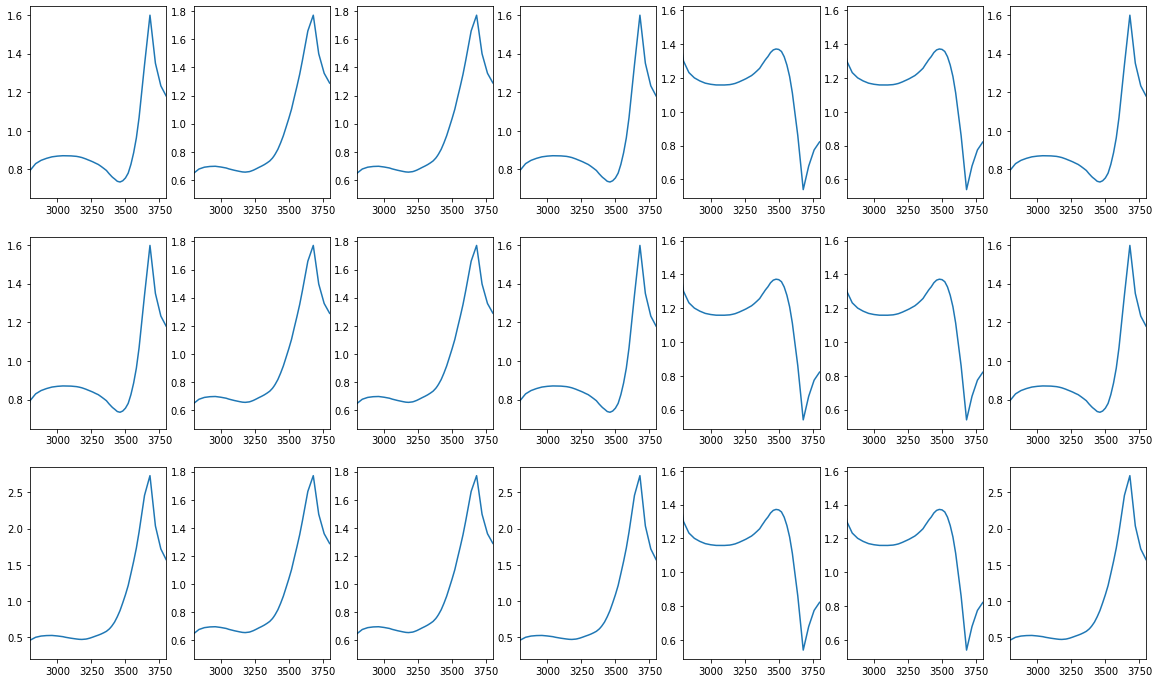

In [37]:
flag_y = False
flag_x = False
xmin,xmax = 2800,3800
divide_spec()

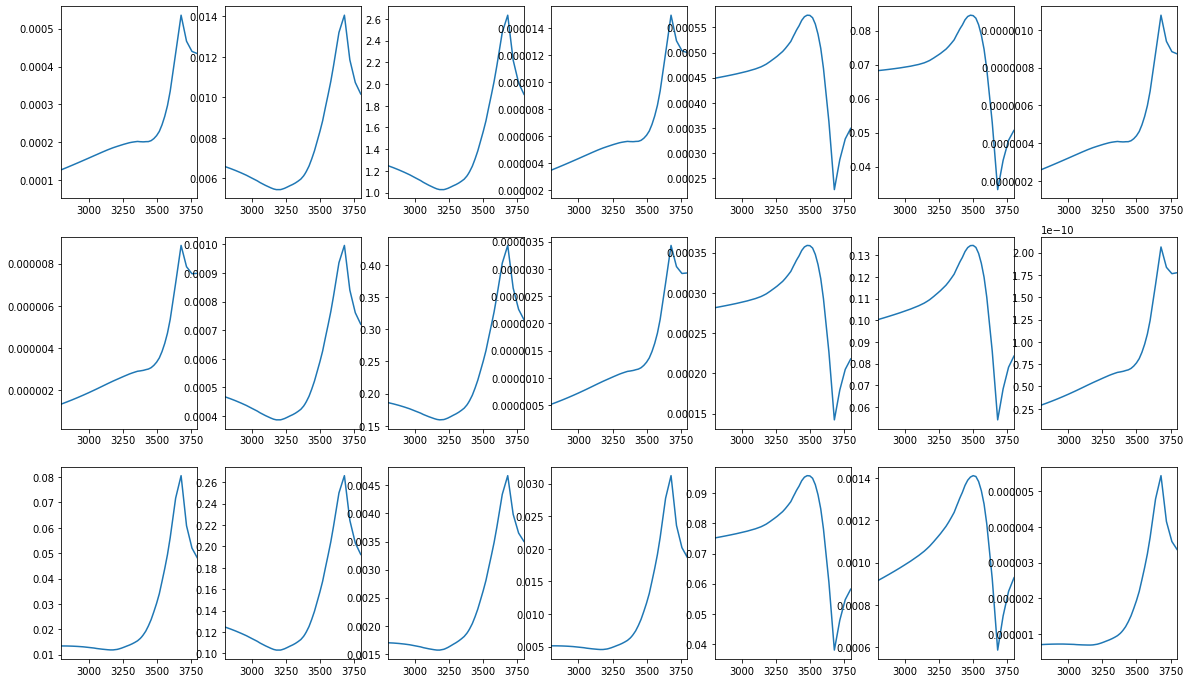

In [38]:
water_spec()

In [39]:
spec_names = ['SSP_I', 'SPS_I', 'PSS_I', 'PPP_I_xxz', 'PPP_I_xzx', 'PPP_I_zxx', 'PPP_I_zzz',
              'SSP_II_n', 'SPS_II_n', 'PSS_II_n', 'PPP_II_xxz_n', 'PPP_II_xzx_n', 'PPP_II_zxx_n', 'PPP_II_zzz_n',
              'SSP_II_w', 'SPS_II_w', 'PSS_II_w', 'PPP_II_xxz_w', 'PPP_II_xzx_w', 'PPP_II_zxx_w', 'PPP_II_zzz_w']   
L_names = ['L_I_xx_ir_sq', 'L_I_yy_ir_sq', 'L_I_zz_ir_sq',
           'L_II_xx_ir_sq', 'L_II_yy_ir_sq', 'L_II_zz_ir_sq_n',
           'L_II_xx_ir_sq', 'L_II_yy_ir_sq', 'L_II_zz_ir_sq_w']
spec_dict = {}
for i in range(len(spec_names)):
    spec_dict[i] = spec_names[i]
L_dict = {}
for i in range(len(L_names)):
    L_dict[i] = L_names[i]

def get_df(data, dic, ind):
    test = []
    for ii in data:
        for jj in ii:
            test.append(jj)
    test1 = pd.DataFrame(test).T
    test1['wavenumber']=ind
    test1 = test1.set_index('wavenumber')
    test2 = test1.rename(columns=dic)
    return test2.loc[:,~test2.columns.duplicated()]

df_L_h2o = get_df(L_h2o, L_dict, x_wn)
df_spec_h2o = get_df(spec_h2o, spec_dict, x_wn)
df_L_d2o = get_df(L_d2o_new, L_dict, x_wn)
df_spec_d2o = get_df(spec_d2o_new, spec_dict, x_wn)
df_L_div = get_df(div_L, L_dict, x_wn)
df_spec_div = get_df(div_spec, spec_dict, x_wn)

def save_df(name='', flag=True):
    if flag:
        folder_name = dt.datetime.now().strftime('%Y-%m-%d') + '_' + name
        outputpath = f'/Users/ricoxi/Desktop/Coding/Fresnel Factor/Results/{folder_name}/'
        if not os.path.exists(outputpath):
            os.makedirs(outputpath)
        
        df_L_h2o.to_csv(outputpath + 'L_h2o.csv')
        df_spec_h2o.to_csv(outputpath + 'spec_h2o.csv')
        df_L_d2o.to_csv(outputpath + 'L_d2o.csv')
        df_spec_d2o.to_csv(outputpath + 'spec_d2o.csv')
        df_L_div.to_csv(outputpath + 'L_div.csv')
        df_spec_div.to_csv(outputpath + 'spec_div.csv')
                
print('='*50+'\nUse \'df_\' + \'L_/spec_\' + name \nto look at the' \
    'dataframe of interest.\n\nCall save_df() to save dataframes.'\
      '\nData saved to \'Results\' folder with datetime.\n'+'='*50)

Use 'df_' + 'L_/spec_' + name 
to look at thedataframe of interest.

Call save_df() to save dataframes.
Data saved to 'Results' folder with datetime.


In [40]:
# save_df(name=f'{θ_air_IR}_{θ_air_vis}')